In [ ]:
import cv2                       # OpenCV for webcam and drawing
import numpy as np               # For image arrays
import pandas as pd              # For logging emotions 
import matplotlib.pyplot as plt  # For emotion plotting 

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, load_img
)


## Loading and Preprocessing Data 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = 'train'
test_dir = 'test'

# Parameters
img_size = 224
batch_size = 32 

# Data generator with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,         # rotate images up to 15 degrees
    width_shift_range=0.1,     # shift width by up to 10%
    height_shift_range=0.1,    # shift height by up to 10%
    zoom_range=0.1,            # zoom in by up to 10%
    horizontal_flip=True       # randomly flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode='rgb',              # Convert grayscale to RGB
    batch_size=batch_size,
    class_mode='categorical',      # One-hot encoding
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Data Distribution

angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprise: 3171 images


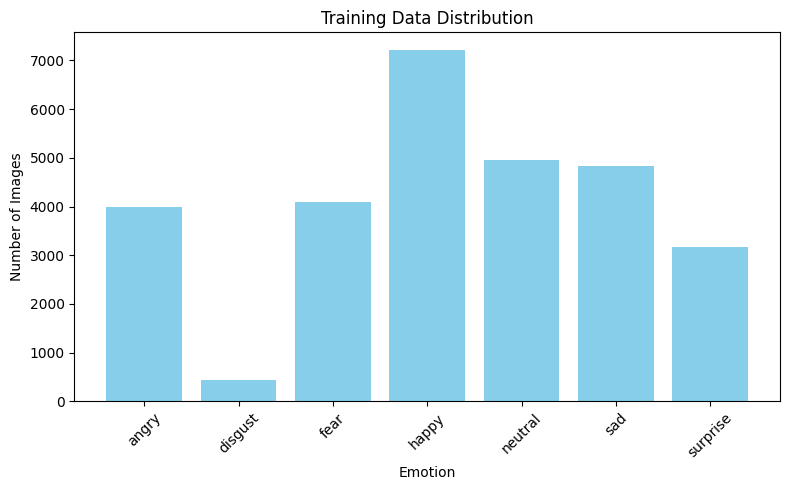

In [ ]:
import os

train_dir = 'train'  

class_counts = {}

# Loop through each class folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the counts
for emotion, count in sorted(class_counts.items()):
    print(f"{emotion}: {count} images")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Training Data Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## MobileNet Model

In [28]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNet base (excluding top)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)



# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,236,039 (12.34 MB)

 Trainable params: 7,175 (28.03 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

## Early Stopping and Check Point

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model only (based on validation loss)
checkpoint = ModelCheckpoint(
    'best_model.keras',          # filename to save the best model
    monitor='val_loss',          # monitor validation loss
    save_best_only=True,         # only save model if val_loss improves
    mode='min',                  # minimize val_loss
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Train the model with both callbacks
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


c:\Users\Maryum\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2052 - loss: 2.1886
Epoch 1: val_loss improved from inf to 1.65424, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 1112s 1s/step - accuracy: 0.2052 - loss: 2.1885 - val_accuracy: 0.3596 - val_loss: 1.6542
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.3011 - loss: 1.8361
Epoch 2: val_loss improved from 1.65424 to 1.54833, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 956s 1s/step - accuracy: 0.3012 - loss: 1.8361 - val_accuracy: 0.4046 - val_loss: 1.5483
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.3436 - loss: 1.7240
Epoch 3: val_loss improved from 1.54833 to 1.49352, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 692s 770ms/step - accuracy: 0.3436 - loss: 1.7240 - val_accuracy: 0.4291 - val_loss: 1.4935
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3665 - loss: 1.6538
Epoch 4: val_loss improved from 1.49352 to 1.

In [ ]:
from keras.models import load_model

model = load_model('best_model.keras')  


## Performance Evaluation

In [45]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")


Classification Accuracy: 50.03%


In [41]:
import numpy as np

# Ensure all test data is evaluated
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Predict
pred_probs = model.predict(test_generator, steps=steps, verbose=1)

# Convert predictions to label indices
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes[:len(y_pred)]  # Match size


225/225 ━━━━━━━━━━━━━━━━━━━━ 139s 616ms/step


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)




Classification Report:
               precision    recall  f1-score   support

       angry       0.43      0.29      0.34       958
     disgust       0.33      0.01      0.02       111
        fear       0.36      0.23      0.28      1024
       happy       0.57      0.82      0.67      1774
     neutral       0.46      0.47      0.47      1233
         sad       0.42      0.40      0.41      1247
    surprise       0.61      0.65      0.63       831

    accuracy                           0.50      7178
   macro avg       0.46      0.41      0.40      7178
weighted avg       0.48      0.50      0.48      7178



## Real-time emotion detection

In [51]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load the trained model
model = load_model("best_model.keras")

# Emotion labels (match your class_indices)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Flip for mirror view
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw rectangle
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 2)

        # Extract face, resize, and preprocess
        face_img = frame[y:y + h, x:x + w]
        face_img = cv2.resize(face_img, (224, 224))
        face_array = np.expand_dims(face_img, axis=0)
        face_array = preprocess_input(face_array)

        # Predict
        preds = model.predict(face_array)
        label_idx = np.argmax(preds)
        label = emotion_labels[label_idx]

        # Show label
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 255, 0), 2)

    cv2.imshow("Real-Time Emotion Detection", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━